In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('Loaded %i result files.' % len(results))
print('Columns/units:')
print(units)
print()

loading ./runs/pure-1-2-30-0-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-0-POSIX/result_summary.txt
loading ./runs/pure-1-2-30-1-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-1-POSIX/result_summary.txt
loading ./runs/pure-1-2-30-2-MPIIO/result_summary.txt
loading ./runs/pure-1-2-30-2-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-0-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-0-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-1-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-1-POSIX/result_summary.txt
loading ./runs/pure-1-2-300-2-MPIIO/result_summary.txt
loading ./runs/pure-1-2-300-2-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-0-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-0-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-1-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-1-POSIX/result_summary.txt
loading ./runs/pure-1-8-30-2-MPIIO/result_summary.txt
loading ./runs/pure-1-8-30-2-POSIX/result_summary.txt
loading ./runs/pure-1-

In [7]:
# Define utilities
def describe(df):
    """ Given a dataframe, return a dict (constants, variables) where both are dicts keyed by column name:
            - Values in `constants` are the single value from that column.
            - Values in `variables` are a list of sorted unique values from that column.
    """
    constants = {}
    variables = {}
    for c in df.columns:
        vs = set(df[c])
        if len(vs) == 1:
            constants[c] = df[c].iloc[0]
        else:
            variables[c] = sorted(list(vs))
    return constants, variables

# Characterise columns as bandwidth, IOPs, or descriptive:
# print('units:', units)
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)
descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)
bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)

print('Test matrix summary:')
result_consts, result_vars = describe(results[descr_cols])
for k, v in result_consts.items():
    print(k, ':', v)
for k, v in result_vars.items():
    print(k,':', list(v))

score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'git_describe', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']
Test matrix summary:
filesystem.name : pure
filesystem.mountpoint : /work/stackhpc-pure/
time : 2:0:0
git_describe : heads/main-0-g3119f9a-dirty
nodes : [1, 2]
ntasks_per_node : [2, 8, 16]
stonewall : [30, 300]
iters : [0, 1, 2]
ior_api : ['MPIIO', 'POSIX']


In [8]:
def split_tests(df):
    """ Split a dataframe into separate bandwidth and IOPS dataframes, contained in a "metrics" dict """
    bw_results = df[descr_cols + bw_cols]
    iops_results = df[descr_cols + iops_cols]
    score_results = df[score_cols]

    metrics = {
        'bandwidth': {
            'name': 'Bandwidth',
            'cols': bw_cols,
            'results': bw_results,
            'unit': bw_unit,
        },
        'iops': {
            'name': 'IOPs',
            'cols': iops_cols,
            'results': iops_results,
            'unit': iops_unit,
        },
        # 'score': {
        #     'name': 'score',
        #     'cols': score_cols,
        #     'results': score_results,
        #     'unit': 'various',
    }
    return metrics

In [9]:
def simple_plot(groupby, x_col, kind='line'):
    """ Produce a set of plots for each group. Each set contains plots for all metrics. """
    for v, grp_results in results.groupby(groupby):
        metrics = split_tests(grp_results)
        for ix, metric in enumerate(metrics.values()):
            grp_constants, grp_vars = describe(grp_results[descr_cols])
            grp_common = ', '.join([f'{k}={v}' for k, v in grp_constants.items()])
            grp_results.plot(x=x_col, y=metric['cols'], kind=kind,title=str(grp_common), style='+')
            xlabel = f'{ x_col }: { str({c:grp_vars[c] for c in grp_vars if c != x_col}) }'
            
            #plt.xlabel(str(grp_vars))
            plt.xlabel(xlabel)
            plt.ylabel(f"{ metric['name'] } ({ metric['unit'] })")
            plt.tight_layout()
            plt.legend(loc=(1,0))
            plt.grid()

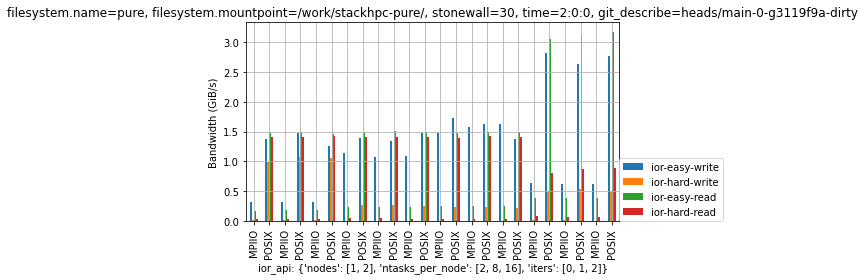

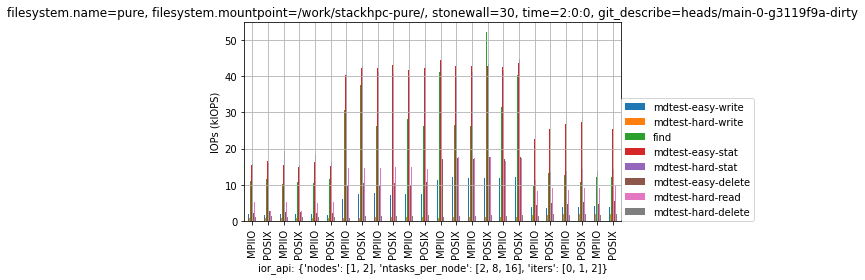

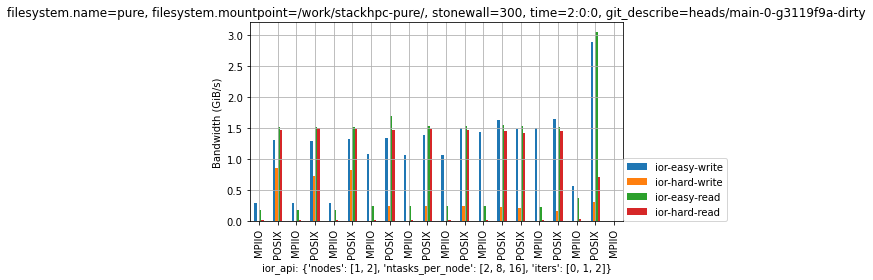

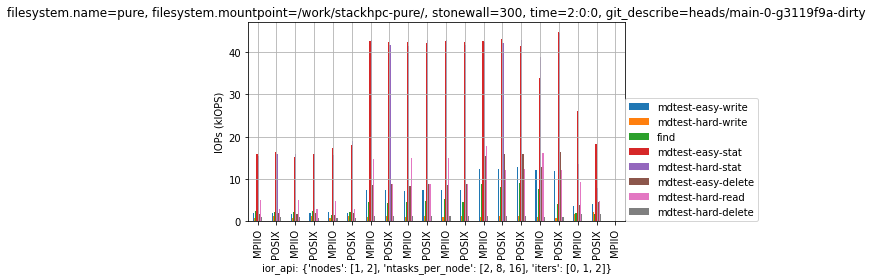

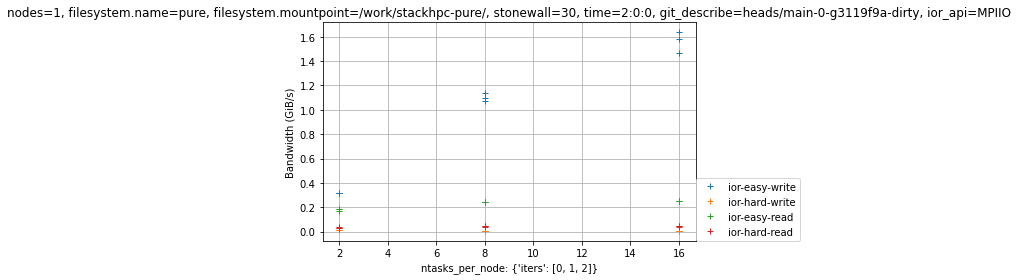

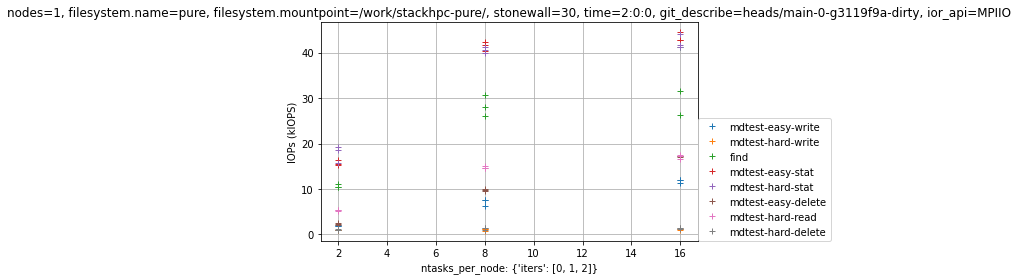

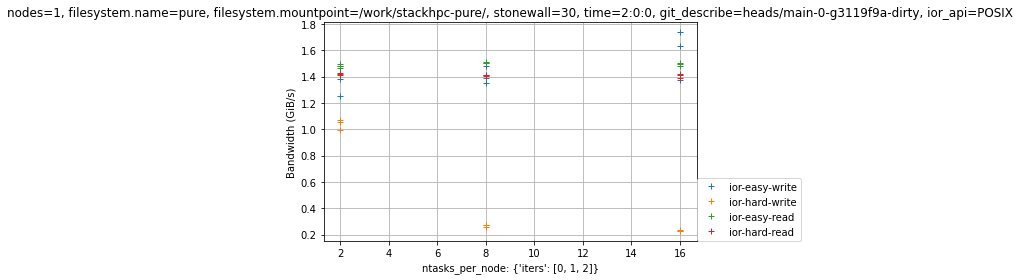

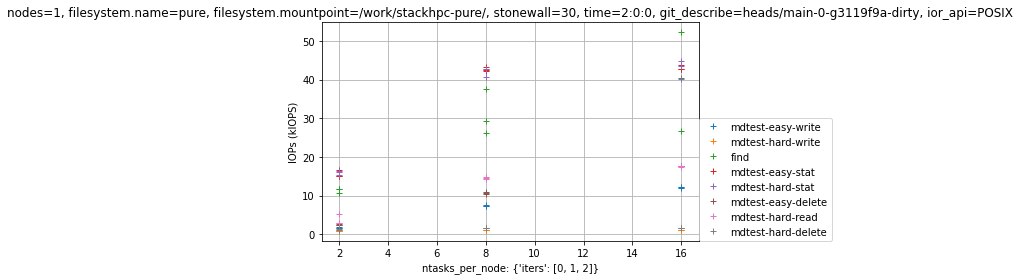

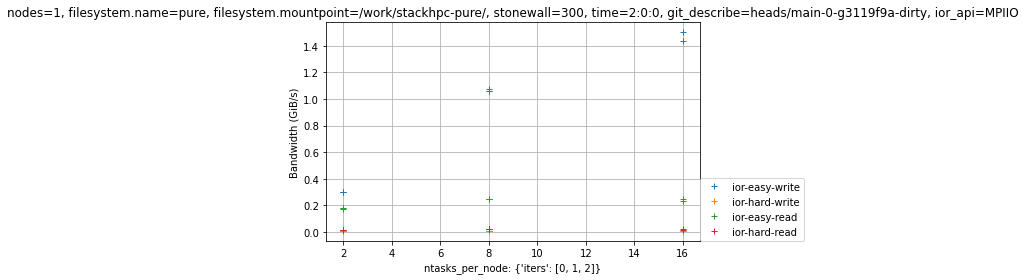

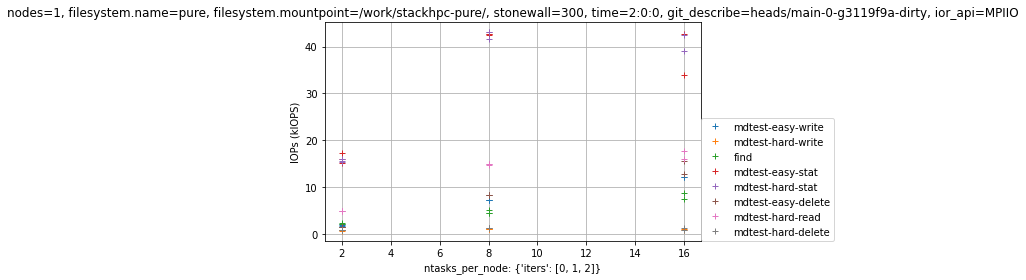

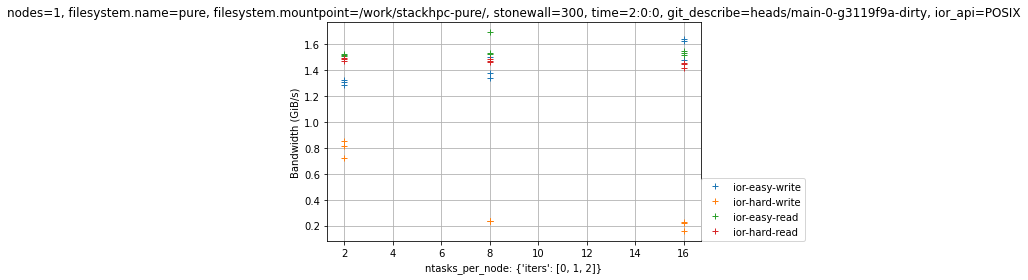

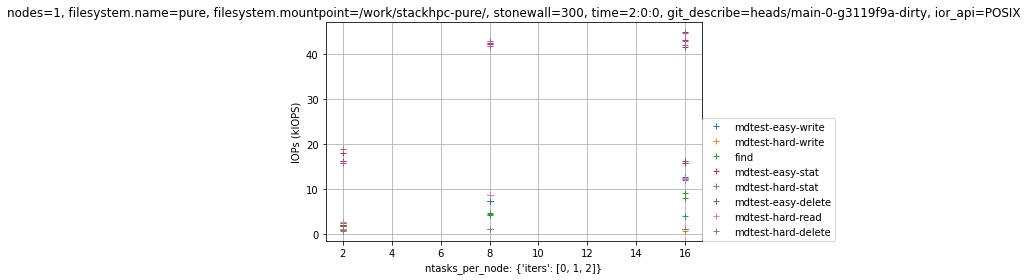

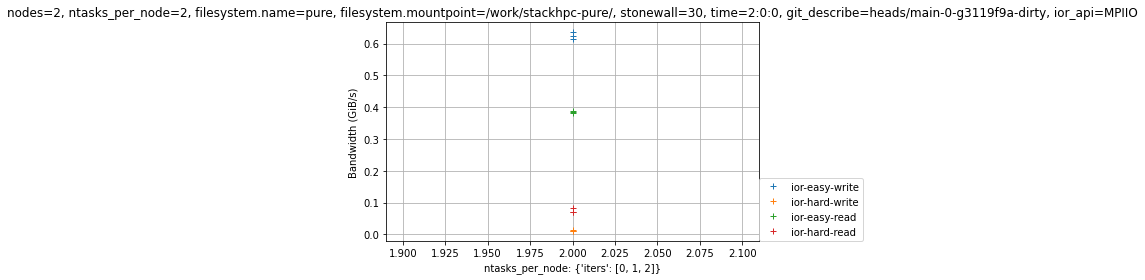

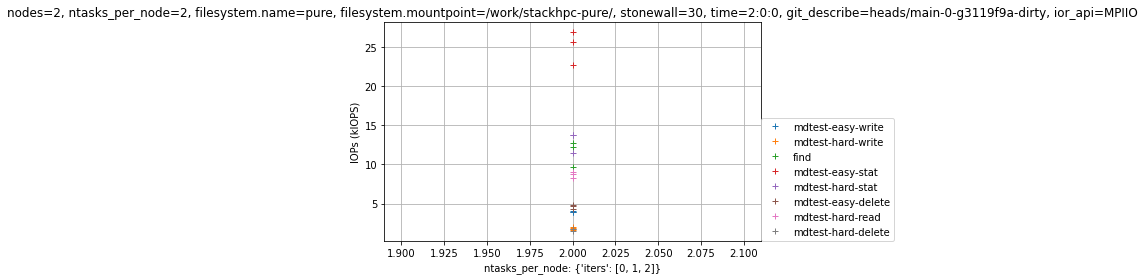

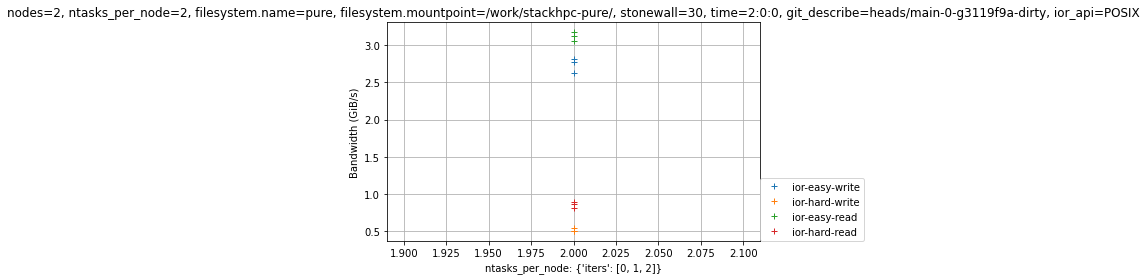

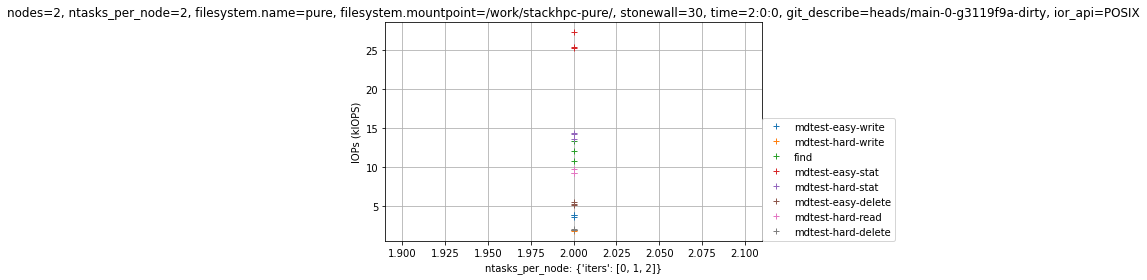

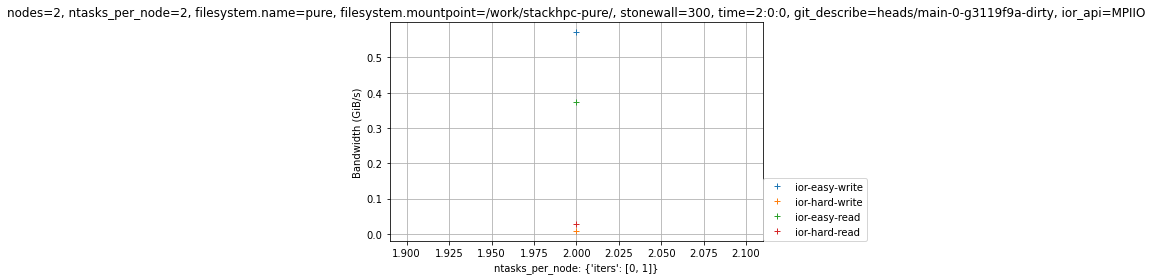

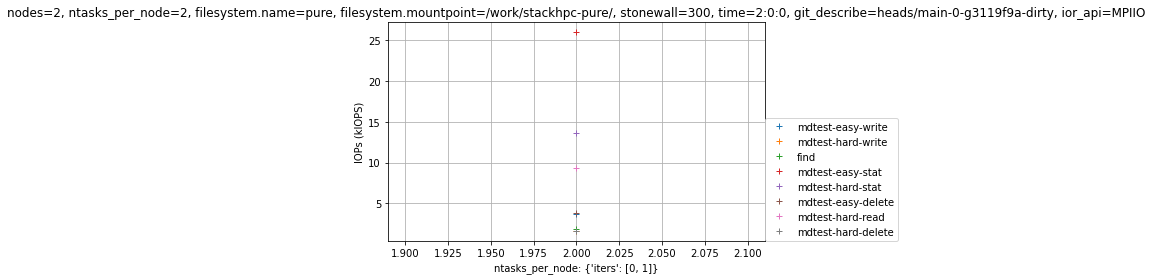

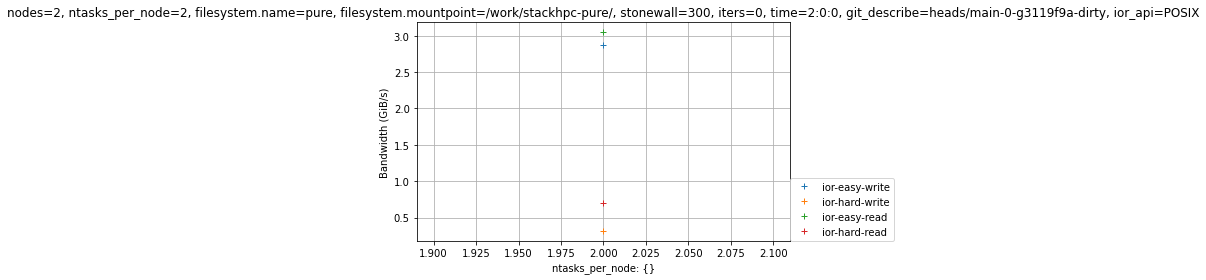

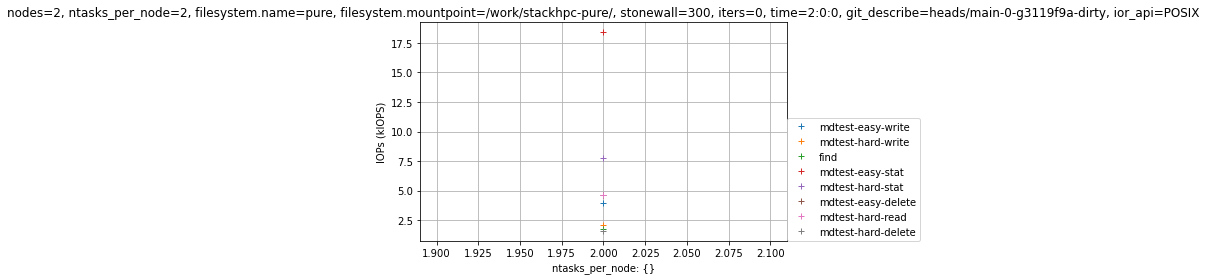

In [10]:
simple_plot(['stonewall'], 'ior_api', 'bar')
simple_plot(['nodes', 'stonewall', 'ior_api'], 'ntasks_per_node')